In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv("diabetic_data.csv")
mapping = pd.read_csv("IDS_mapping.csv")

print("Initial Shape:", df.shape)
print(df.head())

Initial Shape: (101766, 50)
   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No 

In [7]:
# Extract admission type data (rows 0-7)
ad_type = mapping[mapping['admission_type_id'].notna() & (mapping['admission_type_id'] != '')]
ad_type = ad_type[['admission_type_id', 'description']].dropna()
ad_type.columns = ['admission_type_id', 'admission_type_desc']

# Convert to numeric, handling errors
ad_type['admission_type_id'] = pd.to_numeric(ad_type['admission_type_id'], errors='coerce')
ad_type = ad_type.dropna(subset=['admission_type_id'])
ad_type['admission_type_id'] = ad_type['admission_type_id'].astype(int)

# Merge into main dataset
df = df.merge(ad_type, on='admission_type_id', how='left')

print("After merging:", df.shape)

After merging: (300007, 51)


In [8]:
df.replace("?", np.nan, inplace=True)

# Fill missing categorical values with mode
for col in df.select_dtypes(include="object"):
    df[col] = df[col].fillna(df[col].mode()[0])

# Drop useless IDs
df.drop(["encounter_id", "patient_nbr"], axis=1, inplace=True)

In [9]:
df["readmitted_binary"] = df["readmitted"].apply(lambda x: 1 if x == "<30" else 0)

In [10]:
target = "readmitted_binary"
X = df.drop(columns=[target, "readmitted"])
y = df[target]

In [11]:
cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(exclude="object").columns

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)
    ]
)

In [12]:
model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", GradientBoostingClassifier())
])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [14]:
model.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [15]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print("AUC Score:", auc)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

AUC Score: 0.6827415719969309
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     53305
           1       0.71      0.01      0.02      6697

    accuracy                           0.89     60002
   macro avg       0.80      0.51      0.48     60002
weighted avg       0.87      0.89      0.84     60002

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     53305
           1       0.71      0.01      0.02      6697

    accuracy                           0.89     60002
   macro avg       0.80      0.51      0.48     60002
weighted avg       0.87      0.89      0.84     60002



In [16]:
def risk_category(prob):
    if prob < 0.33:
        return "Low"
    elif prob < 0.66:
        return "Medium"
    else:
        return "High"

df["risk_probability"] = model.predict_proba(X)[:, 1]
df["risk_category"] = df["risk_probability"].apply(risk_category)

In [17]:
df.to_csv("patient_risk_output.csv", index=False)
print("Saved: patient_risk_output.csv")

Saved: patient_risk_output.csv


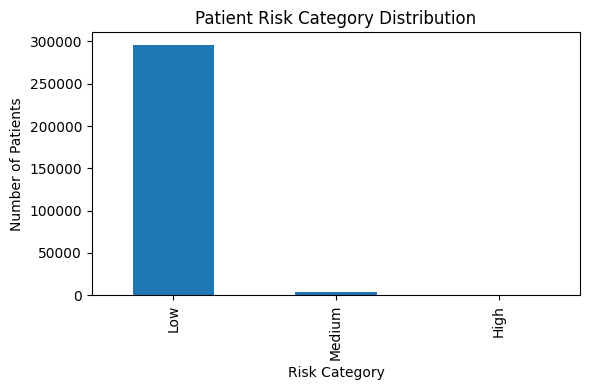

In [18]:
import matplotlib.pyplot as plt

# Example: risk categories from your model
plt.figure(figsize=(6,4))
df['risk_category'].value_counts().plot(kind='bar')

plt.title("Patient Risk Category Distribution")
plt.xlabel("Risk Category")
plt.ylabel("Number of Patients")
plt.tight_layout()
plt.show()


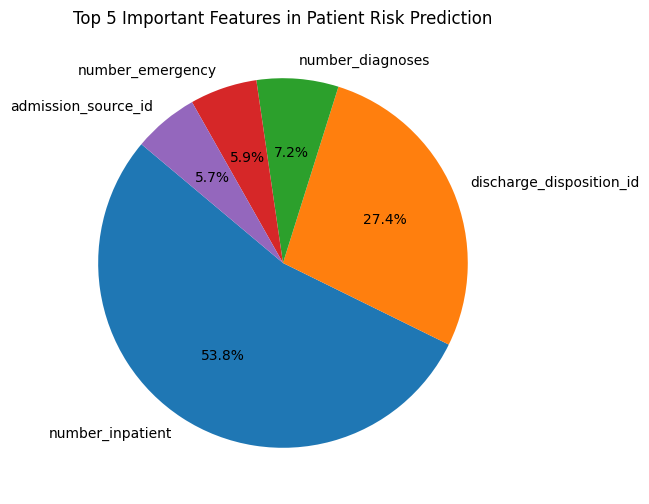

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

# -------------------------
# 1. Load Data
# -------------------------
df = pd.read_csv("diabetic_data.csv")

# Select target and features
target = 'readmitted'
X = df.drop([target, 'encounter_id', 'patient_nbr'], axis=1)
y = df[target]

# Encode categorical columns
for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------------
# 2. Train Gradient Boosting
# -------------------------
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

# -------------------------
# 3. Get Top Features
# -------------------------
importances = model.feature_importances_
feature_names = X.columns

top_n = 5
indices = np.argsort(importances)[::-1][:top_n]
top_features = feature_names[indices]
top_importances = importances[indices]

# -------------------------
# 4. Simple Pie Chart
# -------------------------
plt.figure(figsize=(6,6))
plt.pie(top_importances, labels=top_features, autopct='%1.1f%%', startangle=140)
plt.title("Top 5 Important Features in Patient Risk Prediction")
plt.show()


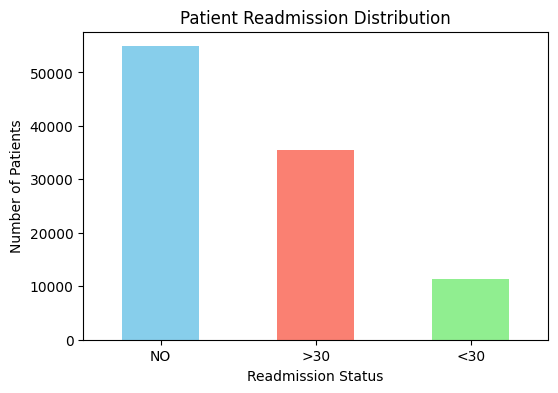

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("diabetic_data.csv")

# Count of patients in each readmission category
readmit_counts = df['readmitted'].value_counts()

# Bar chart
plt.figure(figsize=(6,4))
readmit_counts.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen'])
plt.title("Patient Readmission Distribution")
plt.xlabel("Readmission Status")
plt.ylabel("Number of Patients")
plt.xticks(rotation=0)
plt.show()
